<a name='1'></a>
## 1 - Packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split

import os
import shutil

<a name='2'></a>
## 2 - Data Preparation

The HAM10000 dataset is a collection of $10,015$ skin lesion images corresponding each of them to one of the following classes: 
- Melanocytic nevi (`nv`) *[6705 images]*
- Melanoma (`mel`) *[1113 images]*
- Benign keratosis-like lesions (`bkl`) *[1099 images]*
- Basal cell carcinoma (`bcc`) *[514 images]*
- Actinic keratoses (`akiec`) *[327 images]*
- Vascular lesions (`va`) *[142 images]*
- Dermatofibroma (`df`) *[115 images]*

*[Total images = 10015]*

### Create the directory structure

In [2]:
base_directory = 'base_directory'
os.mkdir(base_directory)

train_directory = os.path.join(base_directory, 'train_directory')
os.mkdir(train_directory)

validation_directory = os.path.join(base_directory, 'validation_directory')
os.mkdir(validation_directory)

test_directory = os.path.join(base_directory, 'test_directory')
os.mkdir(test_directory)

directory = [train_directory, validation_directory, test_directory]
classes = ['nv', 'mel', 'bkl', 'bcc', 'akiec', 'vasc', 'df']

for dirc in directory:
    for cls in classes:
        path = os.path.join(dirc, cls)
        os.mkdir(path)

#### Create train, test and validation sets

In [3]:
df_data = pd.read_csv('../input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')
df_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


#### Create a stratified validation and test set

Although the dataset consists of 10,015 skin lesion images, examination of the metadata indicates that there are only 7,470 distinct skin lesions. The remaining images are duplicates of different magnifications or different angles of view.

Implementing the concept of stratified sampling in cross-validation ensures the training and test sets have the same proportion of the feature of interest as in the original dataset.

In [4]:
# number of images associated with each lesion_id
df = df_data.groupby('lesion_id').count()

# lesion_ids' that have only one image associated with them
df = df[df['image_id'] == 1]

df.reset_index(inplace=True)

df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000001,1,1,1,1,1,1
1,HAM_0000003,1,1,1,1,1,1
2,HAM_0000004,1,1,1,1,1,1
3,HAM_0000007,1,1,1,1,1,1
4,HAM_0000008,1,1,1,1,1,1


We create a new column **duplicates** that has the value *has_duplicates* (if the corresponding **lesion_id** has duplicate images) or *no_duplicates* (if the corresponding **lesion_id** has no duplicate images).

#### Identify the lesion_id's that have duplicate images and those that have only one image

In [5]:
# lesion_id's that have duplicate images and those that have only one image

def identify_duplicates(x):
    unique_list = list(df['lesion_id'])
    if x in unique_list:
        return 'no_duplicates'
    else:
        return 'has_duplicates'
    
# create a new colum that is a copy of the lesion_id column
df_data['duplicates'] = df_data['lesion_id']
# apply the function to this new column
df_data['duplicates'] = df_data['duplicates'].apply(identify_duplicates)

df_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,duplicates
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,has_duplicates
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,has_duplicates
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,has_duplicates
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,has_duplicates
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,has_duplicates


In [6]:
df_data['duplicates'].value_counts()

no_duplicates     5514
has_duplicates    4501
Name: duplicates, dtype: int64

In [7]:
# filter out images that don't have duplicates
df = df_data[df_data['duplicates'] == 'no_duplicates']

df.shape

(5514, 8)

We create the validation set and test set using the filtered dataframe `df` because We are sure that none of these images have augmented images in the train set.

In [8]:
# create the validation and test set
y = df['dx']
df_, df_test = train_test_split(df, test_size=0.20, random_state=101, stratify=y)

y = df_['dx']
_, df_validation = train_test_split(df_, test_size=0.20, random_state=101, stratify=y)

print(df_test.shape)
print(df_validation.shape)

(1103, 8)
(883, 8)


#### Create a train set that excludes images that are in the validation and test set

In [9]:
# This set will be df_data excluding all rows that are in the validation set and test set

# identifies if an image is part of the train, test or val set
def identify_validation_rows(x):
    validation_list = list(df_validation['image_id'])
    test_list = list(df_test['image_id'])
    if str(x) in validation_list:
        return 'validation'
    elif str(x) in test_list:
        return 'test'
    else:
        return 'train'


# create a new colum that is a copy of the image_id column
df_data['train_test_or_validation'] = df_data['image_id']
# apply the function to this new column
df_data['train_test_or_validation'] = df_data['train_test_or_validation'].apply(identify_validation_rows)
   
# filter out train rows
df_train = df_data[df_data['train_test_or_validation'] == 'train']

In [10]:
print("Number of images in the Train Set = ", len(df_train))
df_train['dx'].value_counts()

Number of images in the Train Set =  8029


nv       5115
mel      1030
bkl       940
bcc       451
akiec     273
vasc      119
df        101
Name: dx, dtype: int64

In [11]:
print("Number of images in the Validation Set = ", len(df_validation))
df_validation['dx'].value_counts()

Number of images in the Validation Set =  883


nv       707
bkl       71
mel       37
bcc       28
akiec     24
vasc      10
df         6
Name: dx, dtype: int64

In [12]:
print("Number of images in the Test Set = ", len(df_test))
df_test['dx'].value_counts()

Number of images in the Test Set =  1103


nv       883
bkl       88
mel       46
bcc       35
akiec     30
vasc      13
df         8
Name: dx, dtype: int64

#### Transfer the images into the train, test and validation directories

In [13]:
# get the image_id as the index in df_data
df_data.set_index('image_id', inplace=True)

In [14]:
def transfer_images(images_list, directory):
    for image in images_list:
        fname = image + '.jpg'
        label = df_data.loc[image,'dx']
        
        if fname in images_folder_1:
            # source path to image
            source_path = os.path.join('../input/skin-cancer-mnist-ham10000/ham10000_images_part_1', fname)
            # destination path to image
            destination_path = os.path.join(directory, label, fname)
            # copy the image from the source to the destination
            shutil.copyfile(source_path, destination_path)
    
        if fname in images_folder_2:
            # source path to image
            source_path = os.path.join('../input/skin-cancer-mnist-ham10000/ham10000_images_part_2', fname)
            # destination path to image
            destination_path = os.path.join(directory, label, fname)
            # copy the image from the source to the destination
            shutil.copyfile(source_path, destination_path)


# get a list of images in each of the two folders
images_folder_1 = os.listdir('../input/skin-cancer-mnist-ham10000/ham10000_images_part_1')
images_folder_2 = os.listdir('../input/skin-cancer-mnist-ham10000/ham10000_images_part_2')

# get a list of Train and Validation images
train_images_list = list(df_train['image_id'])
validation_images_list = list(df_validation['image_id'])
test_images_list = list(df_test['image_id'])

transfer_images(train_images_list, train_directory)
transfer_images(validation_images_list, validation_directory)
transfer_images(test_images_list, test_directory)

#### Check how many images are in each of the 7 folders inside `train_directory`, `test_directory` and `val_directory`

In [15]:
directory = [train_directory, validation_directory, test_directory]
classes = ['nv', 'mel', 'bkl', 'bcc', 'akiec', 'vasc', 'df']

for dirc in directory:
    print(dirc)
    for cls in classes:
        path = os.path.join(dirc, cls)
        print(f"{cls}    : ", len(os.listdir(path)))

base_directory/train_directory
nv    :  5115
mel    :  1030
bkl    :  940
bcc    :  451
akiec    :  273
vasc    :  119
df    :  101
base_directory/validation_directory
nv    :  707
mel    :  37
bkl    :  71
bcc    :  28
akiec    :  24
vasc    :  10
df    :  6
base_directory/test_directory
nv    :  883
mel    :  46
bkl    :  88
bcc    :  35
akiec    :  30
vasc    :  13
df    :  8


#### Data augmentation

In [16]:
# note that we are not augmenting class 'nv' as it already has a lot of images (close to 5200)
class_list = ['mel','bkl','bcc','akiec','vasc','df']

for item in class_list:
    
    # create temporary directories
    
    # create base_augmentation_directory
    base_augmentation_directory = 'base_augmentation_directory' 
    os.mkdir(base_augmentation_directory)

    # create image_directory within base_augmentation_directory to store images of the same class
    image_directory = os.path.join(base_augmentation_directory, 'image_directory')
    os.mkdir(image_directory)
    
    # choose a class
    image_class = item
    
    # list all images in that directory
    image_list = os.listdir('base_directory/train_directory/' + image_class)

    # copy images from the class train_directory to the image_directory e.g. class 'mel'
    for fname in image_list:
            # source path to image
            source_path = os.path.join('base_directory/train_directory/' + image_class, fname)
            # destination path to image
            destination_path = os.path.join(image_directory, fname)
            # copy the image from the source to the destination
            shutil.copyfile(source_path, destination_path)


    # point to a directory containing the images and not to the images themselves
    path = base_augmentation_directory
    save_path = 'base_directory/train_directory/' + image_class

    # create a data generator
    datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        # brightness_range=(0.9,1.1),
        fill_mode='nearest')

    BATCH_SIZE = 50

    augmentation_datagen = datagen.flow_from_directory(path,
                                                       save_to_dir=save_path,
                                                       save_format='jpg',
                                                       target_size=(224,224),
                                                       batch_size=BATCH_SIZE)
    # generate the augmented images and add them to the training folders
    
    ###########
    
    num_augmented_images_wanted = 6000 # total number of images we want to have in each class
    
    ###########
    
    num_files = len(os.listdir(image_directory))
    num_batches = int(np.ceil((num_augmented_images_wanted-num_files)/BATCH_SIZE))

    # run the generator and create about 6000 augmented images
    for i in range(0,num_batches):
        images, labels = next(augmentation_datagen)
        
    # delete temporary directory with the raw image files
    shutil.rmtree('base_augmentation_directory')

Found 1030 images belonging to 1 classes.
Found 940 images belonging to 1 classes.
Found 451 images belonging to 1 classes.
Found 273 images belonging to 1 classes.
Found 119 images belonging to 1 classes.
Found 101 images belonging to 1 classes.


After having done the data augmenation, We check how many images are in each of the 7 folders inside `train_directory`. This is the original images plus the augmented images.

In [17]:
print("nv    : ", len(os.listdir('base_directory/train_directory/nv')))
print("mel   : ", len(os.listdir('base_directory/train_directory/mel')))
print("bkl   : ", len(os.listdir('base_directory/train_directory/bkl')))
print("bcc   : ", len(os.listdir('base_directory/train_directory/bcc')))
print("akiec : ", len(os.listdir('base_directory/train_directory/akiec')))
print("vasc  : ", len(os.listdir('base_directory/train_directory/vasc')))
print("df    : ", len(os.listdir('base_directory/train_directory/df')))

nv    :  5115
mel   :  5950
bkl   :  5990
bcc   :  5462
akiec :  5510
vasc  :  4810
df    :  4090


In [18]:
directory = [train_directory, validation_directory, test_directory]
classes = ['nv', 'mel', 'bkl', 'bcc', 'akiec', 'vasc', 'df']

for dirc in directory:
    print(dirc)
    for cls in classes:
        path = os.path.join(dirc, cls)
        print(f"{cls}    : ", len(os.listdir(path)))

base_directory/train_directory
nv    :  5115
mel    :  5950
bkl    :  5990
bcc    :  5462
akiec    :  5510
vasc    :  4810
df    :  4090
base_directory/validation_directory
nv    :  707
mel    :  37
bkl    :  71
bcc    :  28
akiec    :  24
vasc    :  10
df    :  6
base_directory/test_directory
nv    :  883
mel    :  46
bkl    :  88
bcc    :  35
akiec    :  30
vasc    :  13
df    :  8


#### Visualize 50 augmented images

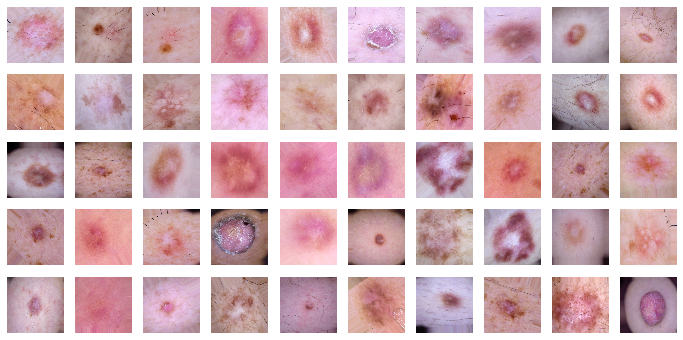

In [19]:
# source: https://github.com/smileservices/keras_utils/blob/master/utils.py

def plots(ims, figsize=(12,6), rows=5, interp=False, titles=None): # 12,6
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')
        
plots(images, titles=None) # titles=labels will display the image labels